### Focus Project Schröder


### GOAL: 
To turn problem set 10 into a cosmological simulation you need two things:
1) Change the time integration to account for the expansion of the Universe (add perturbation in an expanding universe / generic perturbation)
2) Cosmological initial conditions. Here you need to use the power spectrum sampling from page 109 of the lecture notes, with the Zeldovich approximation to displace the particles initially. (study how one can make realisations of cosmic density fields with a cosmological power spectrum and connect this to the material in Section 5.6.2.)

------------------------------------------------------------------------------

In [10]:
import numpy as np
from numba import jit , njit, prange
import matplotlib.pyplot as plt
import mpmath as mp
from matplotlib.colors import LogNorm



Cosmological Helper

In [11]:
# ---------- ΛCDM table (Ωm+ΩΛ=1, neglecting radiation) ----------
import numpy as np
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import interp1d

# ---- parameters (Planck-like) ----
Omega_m = 0.315
Omega_l = 0.685          # = 1 - Ωm  (flat)
Omega_r = 0.0            # keep 0 unless you need z > 1000
H0      = 1.0            # set H(a=1)=1 in *code* units

def H_of_a(a):
    """H(a)/H0  (dimensionless)"""
    return np.sqrt(Omega_m * a**-3 + Omega_r * a**-4 + Omega_l)

# ---- build a ↔ t lookup tables ----
a_grid = np.geomspace(1e-4, 1.0, 20_000)          # log spacing is nice
integrand = 1.0 / (a_grid * H_of_a(a_grid))       # dt/da
t_grid = cumulative_trapezoid(integrand, a_grid, initial=0.0)

# high-accuracy cubic splines
a_of_t = interp1d(t_grid, a_grid, kind='cubic', assume_sorted=True,
                  fill_value="extrapolate")
t_of_a = interp1d(a_grid, t_grid, kind='cubic', assume_sorted=True,
                  fill_value="extrapolate")


Pick start factors


In [12]:
a_init  = 0.02              # z_init ≈ 49
t_start = float(t_of_a(a_init))

Run solvers

In [13]:
'''
# ---------- Cosmology helper ----------
t0 = 1.0                                           # choose code units so a(t0)=1

def a_of_t(t):
    """Scale factor in Einstein-de Sitter (Ωm=1)"""
    return (t / t0) ** (2.0 / 3.0)

def H_of_a(a):
    """H(a) for EdS in same units (unused but handy)"""
    return (2.0 / 3.0) * a ** (-3.0 / 2.0) / t0
'''

# ---------- Cloud-in-Cell routines ----------
@njit(fastmath=True)
def cic_deposit(x, y, w, ngrid):
    """Deposit particle weights onto an ngrid×ngrid mesh (periodic)."""
    rho = np.zeros((ngrid, ngrid))
    N    = x.size
    for i in range(N):
        # wrap to [0,1)
        xi = x[i] % 1.0
        yi = y[i] % 1.0
        # cell indices
        gx = xi * ngrid
        gy = yi * ngrid
        il = int(gx)
        jl = int(gy)
        ir = (il + 1) % ngrid
        jr = (jl + 1) % ngrid
        # weights
        dx = gx - il
        dy = gy - jl
        w00 = (1.0 - dx) * (1.0 - dy) * w[i]
        w01 = (1.0 - dx) * dy         * w[i]
        w10 = dx         * (1.0 - dy) * w[i]
        w11 = dx         * dy         * w[i]
        rho[il, jl] += w00
        rho[il, jr] += w01
        rho[ir, jl] += w10
        rho[ir, jr] += w11
    return rho

@njit(parallel=True, fastmath=True)
def cic_interpolate(x, y, field):
    """Adjoint CIC: sample *field* at particle positions (x,y)."""
    ngrid = field.shape[0]
    N     = x.size
    out   = np.empty(N, dtype=field.dtype)
    for i in prange(N):
        xi = x[i] % 1.0
        yi = y[i] % 1.0
        gx = xi * ngrid
        gy = yi * ngrid
        il = int(gx) % ngrid
        jl = int(gy) % ngrid
        ir = (il + 1) % ngrid
        jr = (jl + 1) % ngrid
        dx = gx - il
        dy = gy - jl
        out[i] = (
            (1.0 - dx) * (1.0 - dy) * field[il, jl] +
            (1.0 - dx) * dy         * field[il, jr] +
            dx         * (1.0 - dy) * field[ir, jl] +
            dx         * dy         * field[ir, jr]
        )
    return out


# ---------- Poisson solver ----------
def poisson_solve(delta):
    """
    Solve ∇²φ = −δ on a periodic mesh (4πG = 1 convention).
    Returns φ, ax, ay   with ax = −∂φ/∂x,  etc.
    """
    N = delta.shape[0]

    # FFT k-space grid
    m  = np.concatenate((np.arange(0, N//2), np.arange(-N//2, 0)))
    k  = 2.0 * np.pi * m
    kx, ky = np.meshgrid(k, k, indexing="ij")
    k2     = kx**2 + ky**2

    # forward FFT
    fdelta = np.fft.fft2(delta)

    # solve Poisson   φ̂ = −δ̂ / k²
    with np.errstate(divide="ignore", invalid="ignore"):
        fphi = -fdelta / k2
    fphi[0, 0] = 0.0                # set mean φ = 0

    # accelerations in k-space
    fax = -1j * kx * fphi
    fay = -1j * ky * fphi

    # inverse FFTs
    phi = np.real(np.fft.ifft2(fphi))
    ax  = np.real(np.fft.ifft2(fax))
    ay  = np.real(np.fft.ifft2(fay))
    return phi, ax, ay


def mesh_accel(rho, a):
    """
    Given mesh density rho, return accelerations ax, ay.
    Implements ∇²φ = a (ρ − ρ̄),  f = −∇φ / a   (4πG = 1).
    """
    delta = a * (rho - rho.mean())
    _, ax, ay = poisson_solve(delta)
    return ax, ay

# ---------- Kick–Drift–Kick leap-frog (FIXED) ----------
def leapfrog_cosmo(
    X, P, m, *, ngrid=64, dt=0.005, n_steps=200, t_start=0.0, store=False
):
    """
    Symplectic PIC integrator in comoving coords.
    X : (N,2) positions in [0,1)
    P : (N,2) canonical momenta  p = a² m ẋ
    """
    X = np.ascontiguousarray(X, dtype=np.float64)
    P = np.ascontiguousarray(P, dtype=np.float64)
    W = np.full(X.shape[0], m)

    t  = t_start
    a  = a_of_t(t)
    hist = [] if store else None

    for step in range(n_steps):
        # ----- Kick (½) at a(t+Δt/2) -----
        a_half   = a_of_t(t + 0.5 * dt)
        rho      = cic_deposit(X[:, 0], X[:, 1], W, ngrid)
        ax_mesh, ay_mesh = mesh_accel(rho, a_half)
        Ax = cic_interpolate(X[:, 0], X[:, 1], ax_mesh)
        Ay = cic_interpolate(X[:, 0], X[:, 1], ay_mesh)
        P[:, 0] += 0.5 * dt * a_half * Ax
        P[:, 1] += 0.5 * dt * a_half * Ay

        # ----- Drift (full) using a_half -----
        X += dt * P / (a_half ** 2)
        X %= 1.0

        # advance time
        t += dt
        a  = a_of_t(t)

        # ----- Kick (½) at new a -----
        rho      = cic_deposit(X[:, 0], X[:, 1], W, ngrid)
        ax_mesh, ay_mesh = mesh_accel(rho, a)
        Ax = cic_interpolate(X[:, 0], X[:, 1], ax_mesh)
        Ay = cic_interpolate(X[:, 0], X[:, 1], ay_mesh)
        P[:, 0] += 0.5 * dt * a * Ax
        P[:, 1] += 0.5 * dt * a * Ay

        # optional history
        if store and (step % 10 == 0 or step == n_steps - 1):
            hist.append((t, a, X.copy(), P.copy()))

    rho_final = cic_deposit(X[:, 0], X[:, 1], W, ngrid)
    return X, P, rho_final, a, t, hist


Run

done: a=269.184,  z=-1.00


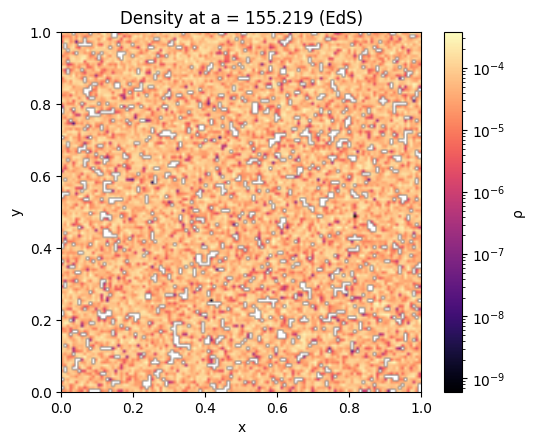

In [16]:
dt      = 0.002          # still in *code* time units where H0=1
n_steps = 6000           # enough to reach a≈1

Xf, Pf, rho_f, a_fin, t_fin, _ = leapfrog_cosmo(
        X, P, m, ngrid=ngrid, dt=dt, n_steps=n_steps, t_start=t_start)
print(f"done: a={a_fin:.3f},  z={1/a_fin-1:.2f}")



# --- Plot final density field ---
plt.figure(figsize=(5.5, 4.5))
plt.imshow(
    rho_f.T,
    origin="lower",
    cmap="magma",
    interpolation="bilinear",
    extent=(0,1,0,1),
    norm=LogNorm()
)
plt.title(f"Density at a = {a_final:.3f} (EdS)")
plt.xlabel("x")
plt.ylabel("y")
cbar = plt.colorbar(label="ρ")
plt.tight_layout()
plt.show()

Example simple test problem

Starting EdS run  a0 = 0.0100,  dt = 0.002,  steps = 5000
Finished at  a = 155.219,  t = 10.0010


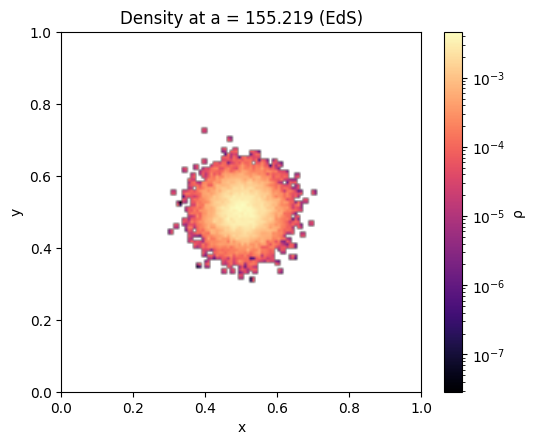

In [15]:

# ---------- Main: simple test problem ----------

# --- Simulation parameters ---
N        = 10000          # number of particles
ngrid    = 128              # mesh resolution
dt       = 0.002            # time step (code time units)
n_steps  = 5000             # total steps  (→ a≈1 from a≈0.01)
t_start  = 0.001            # start time → a_start = (t/t0)^(2/3) ≈ 0.01

# --- Initial particle load: Gaussian blob ---
np.random.seed(42)
sigma_x, sigma_y = 0.05, 0.05
X = np.empty((N, 2))
X[:,0] = (0.5 + sigma_x * np.random.randn(N)) % 1.0
X[:,1] = (0.5 + sigma_y * np.random.randn(N)) % 1.0

# canonical momenta: small random velocities
m  = 1.0 / N
v_disp = 1e-4                # peculiar vel dispersion
P = a_init**2 * m * v_disp * np.random.randn(N, 2)

#a0 = a_of_t(t_start)
#P = a0**2 * m * v_disp * np.random.randn(N, 2)

# --- Run integrator ---
print(f"Starting EdS run  a0 = {a0:.4f},  dt = {dt},  steps = {n_steps}")
Xf, Pf, rho_f, a_final, t_final, _ = leapfrog_cosmo(X, P, m, ngrid=ngrid, dt=dt, n_steps=n_steps, t_start=t_start)
print(f"Finished at  a = {a_final:.3f},  t = {t_final:.4f}")

# --- Plot final density field ---
plt.figure(figsize=(5.5, 4.5))
plt.imshow(
    rho_f.T,
    origin="lower",
    cmap="magma",
    interpolation="bilinear",
    extent=(0,1,0,1),
    norm=LogNorm()
)
plt.title(f"Density at a = {a_final:.3f} (EdS)")
plt.xlabel("x")
plt.ylabel("y")
cbar = plt.colorbar(label="ρ")
plt.tight_layout()
plt.show()